# Final Exam (part 2) - Computational Physics 2

### Deadline: Friday 6 June 2025 (by 23h59)
### Credits: 10 points

### Please keep the structure provided below and submit an organised notebook with clear answers to each item.


## 2. FFT method for fluid dynamics: 1D Shock waves

We wish to study the emergence of 1D shock waves in fluids. To do this we will modify our one-way wave equation to account for non-linear convection, i.e. we will consider that the speed of an initial Gaussian density perturbation $\rho(x, 0) = 4\,e^{-x^2}$ propagating across a periodic 1D domain is not constant, but a function of the density itself, so that our PDE becomes:

$$\frac{\partial \rho}{\partial t} + \rho\frac{\partial \rho}{\partial x} =0$$


As we see from the above equation, portions of $\rho$ with larger amplitudes will convect more rapidly, giving rise to wave steepening (i.e. to a discontinuity, which we call a **shock wave**). Without a diffusive term, the shock would become infinitely steep. Therefore, we add a diffusive (parabolic) term to our PDE so that the shock maintains a finite width. Our PDE then becomes:

$$\frac{\partial \rho}{\partial t} + \rho\frac{\partial \rho}{\partial x} =\alpha\frac{\partial^2 \rho}{\partial x^2}$$

where $\alpha$ is a diffusion constant.

Implement the following tasks using **python classes**:

**(a)** Create an appropriate domain and a reasonable time vector for the problem, and make a plot of the initial density profile.


**(b)** Write a method for the right-hand-side (RHS) of the PDE that allows you to map in and out of the Fourier domain at each time. Note that this PDE is non-linear, so the function should return the RHS in real space. **Hint:** it may be helpful to write the derivative terms in our PDE in Fourier domain.


**(c)** Choose a reasonable value for the diffusion constant, $\alpha$, and call your function in (b). What is this function achieving so far and what space (real or Fourier) is the output in?


**(d)** Find and plot the solution, $\rho(x,t)$, **using your FFT method**. For this, you need to feed a scipy ODE integrator with the function you created in (b). **Hint:** make sure you feed the correct wavenumbers to the ODE integrator.


**(e)** Repeat the above calculations for two additional $\alpha$ values (one of them should be 0). Then, make a figure (or movie) with three panels comparing the results for different $\alpha$ values and briefly discuss the role of this parameter in regulating the morphology of the shock wave.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

class ShockWave1D:
    def __init__(self, N=256, L=20, alpha=0.1):
        """
        Initialize the 1D shock wave simulation.
        
        Parameters:
        N: Number of grid points
        L: Domain length (centered at 0)
        alpha: Diffusion constant
        """
        self.N = N
        self.L = L
        self.alpha = alpha
        
        # Spatial grid
        self.x = np.linspace(-L/2, L/2, N, endpoint=False)
        self.dx = self.x[1] - self.x[0]
        
        # Wavenumbers for FFT
        self.k = 2 * np.pi * np.fft.fftfreq(N, d=self.dx)
        
        # Initial condition: Gaussian density perturbation
        self.rho0 = 4 * np.exp(-self.x**2)
    
    def plot_initial_profile(self):
        """Plot the initial density profile."""
        plt.figure(figsize=(8, 5))
        plt.plot(self.x, self.rho0, 'b-', linewidth=2)
        plt.title(f"Initial Density Profile (α = {self.alpha})")
        plt.xlabel("x")
        plt.ylabel("ρ(x, 0)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def rhs(self, t, rho_real):
        """
        Right-hand side of the PDE: ∂ρ/∂t = -ρ∂ρ/∂x + α∂²ρ/∂x²
        
        Returns the RHS in real space for the ODE integrator.
        """
        # Transform to Fourier space
        rho_hat = np.fft.fft(rho_real)
        
        # Compute spatial derivative ∂ρ/∂x in Fourier space, then transform back
        drho_dx = np.fft.ifft(1j * self.k * rho_hat).real
        
        # Nonlinear convection term: -ρ∂ρ/∂x (computed in real space)
        convection_term = -rho_real * drho_dx
        
        # Diffusion term: α∂²ρ/∂x² (computed in Fourier space, then transformed back)
        diffusion_term = np.fft.ifft(-self.alpha * (self.k ** 2) * rho_hat).real
        
        return convection_term + diffusion_term

    def solve(self, t_max=2.0, n_frames=100):
        """
        Solve the PDE using scipy's ODE integrator.
        
        Returns:
        times: Array of time points
        solutions: Array of density profiles at each time
        """
        t_eval = np.linspace(0, t_max, n_frames)
        
        sol = solve_ivp(self.rhs, [0, t_max], self.rho0,
                       t_eval=t_eval, method='RK45', rtol=1e-8)
        
        return sol.t, sol.y.T  # Transpose to get (time, space) shape

    def plot_evolution(self, times, solutions, step=20, alpha_label=None):
        """Plot the evolution of the density field."""
        plt.figure(figsize=(10, 6))
        
        # Plot every 'step' time frames
        for i in range(0, len(times), step):
            plt.plot(self.x, solutions[i], 
                    label=f't={times[i]:.2f}', alpha=0.8)
        
        title = f'Shock Wave Evolution'
        if alpha_label is not None:
            title += f' (α = {alpha_label})'
        else:
            title += f' (α = {self.alpha})'
            
        plt.title(title)
        plt.xlabel("x")
        plt.ylabel("ρ(x, t)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_comparison(self, alpha_values, t_max=2.0, n_frames=100):
        """Compare solutions for different alpha values."""
        fig, axes = plt.subplots(1, len(alpha_values), figsize=(15, 5))
        if len(alpha_values) == 1:
            axes = [axes]
        
        for i, alpha in enumerate(alpha_values):
            # Create new instance with different alpha
            sim_temp = ShockWave1D(N=self.N, L=self.L, alpha=alpha)
            times, solutions = sim_temp.solve(t_max=t_max, n_frames=n_frames)
            
            # Plot final state
            axes[i].plot(self.x, sim_temp.rho0, 'k--', label='Initial', alpha=0.5)
            axes[i].plot(self.x, solutions[-1], 'r-', linewidth=2, label=f'Final (t={t_max})')
            axes[i].set_title(f'α = {alpha}')
            axes[i].set_xlabel('x')
            axes[i].set_ylabel('ρ(x, t)')
            axes[i].grid(True, alpha=0.3)
            axes[i].legend()
        
        plt.tight_layout()
        plt.show()


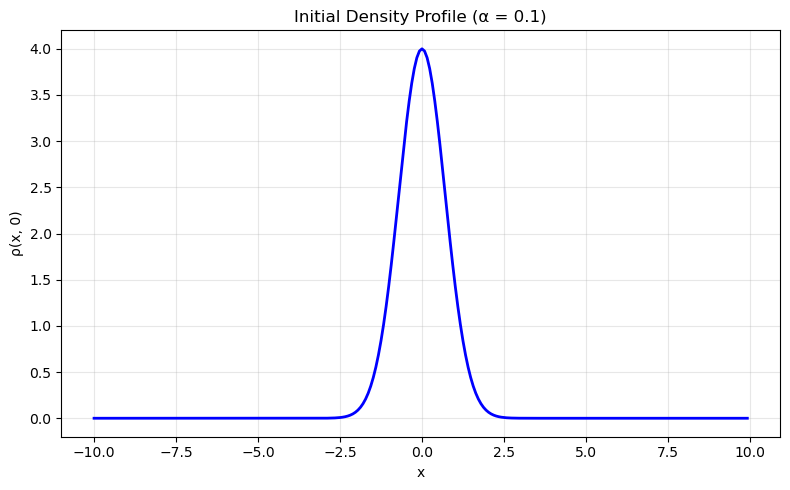

In [2]:
sim = ShockWave1D(N=256, L=20, alpha=0.1)
sim.plot_initial_profile()

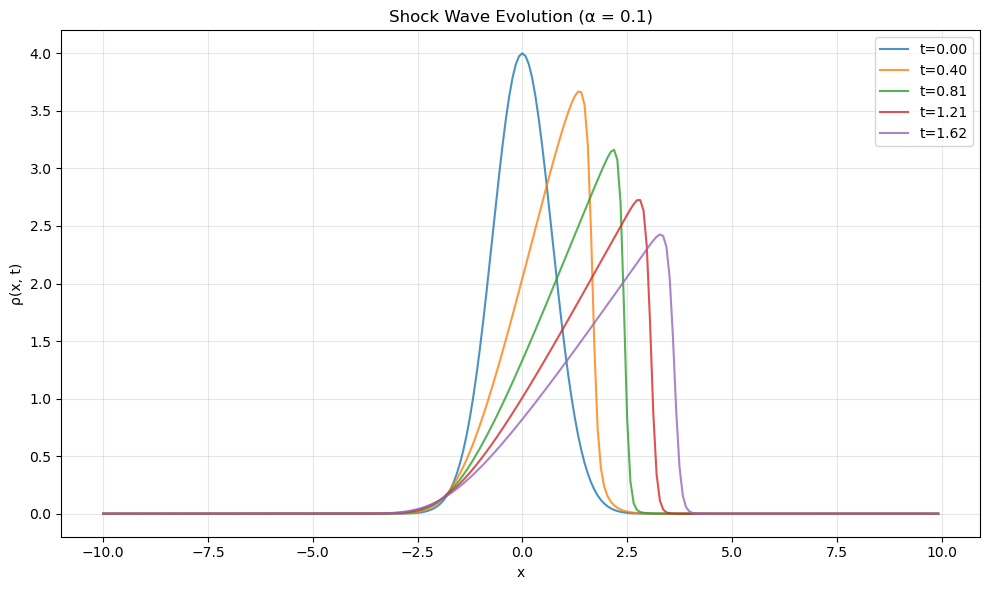

In [3]:
alpha = 0.1
times, rhos = sim.solve(t_max=2.0, n_frames=100)
sim.plot_evolution(times, rhos, step=20)

Output is in real space


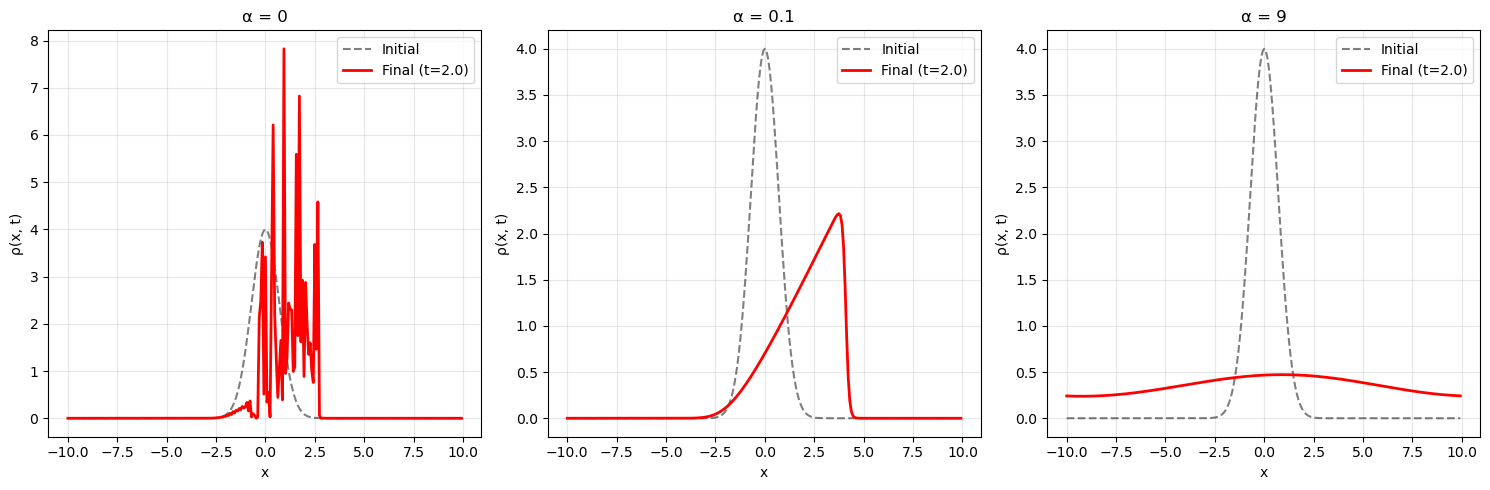

In [4]:
alphas = [0, 0.1, 9]
sim.plot_comparison(alphas, t_max=2.0, n_frames=100)